In [1]:
%load_ext autoreload
%autoreload 2

# Имитационное моделирование

В этом ноутбуке исследуем и валидируем имитационную модель, позволяющую рассчитать вероятность идентификации и другие характеристики нашей системы.

In [7]:
from tabulate import tabulate
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [13]:
from rfidam.simulation import ModelParams, simulate
from rfidam.protocol import LinkProps, Protocol
from rfidlib.protocol.symbols import DR, TagEncoding
from rfidam.scenario import parse_scenario
from rfidam.utils import bcolors, get_err, fmt_err, highlight, pluralize

In [8]:
def fmt_header(s):
    return highlight(s, bcolors.OKBLUE)

def fmt_delim(s):
    return highlight(s, bcolors.OKCYAN)

def fmt_float(x):
    return f'{x:.4f}'

In [10]:
LINK_PROPS = LinkProps(
    tari=12.5e-6,
    rtcal=30e-6,
    trcal=35e-6,
    m=TagEncoding.M2,
    dr=DR.DR_643,
    trext=False,
    q=2,
    use_tid=True,
    t_off=0.1)
PROTOCOL = Protocol(LINK_PROPS)

In [15]:
def build_params(scenario: str, ber: float, arrival_interval: float, num_tags: int, time_in_area: float):
    LENGTH = 10.0
    speed = LENGTH / time_in_area
    arrivals = np.arange(num_tags) * arrival_interval
    return ModelParams( 
        protocol=PROTOCOL, 
        arrivals=arrivals,
        speed=speed,
        length=LENGTH,
        scenario=parse_scenario(scenario),
        ber=ber
    )

In [112]:
def run_sim(params, n_iters = 5):
    journals = [simulate(params) for _ in tqdm(range(n_iters))]
    return journals

In [121]:
def get_num_rounds_active(journals, scenario_length):
    num_rounds_active = [journal.num_rounds_active(scenario_length) for journal in journals]
    means = sum([x.means for x in num_rounds_active]) / len(journals)
    errors = sum([x.errors for x in num_rounds_active]) / len(journals)
    return means, errors

def get_num_tags_active(journals, scenario_length):
    matrix = [journal.num_active(scenario_length) for journal in journals]
    means = sum([x.means for x in matrix]) / len(journals)
    errors = sum([x.errors for x in matrix]) / len(journals)
    return means, errors

def get_id_probs(journals, scenario_length):
    all_probs = np.vstack([journal.id_probs(scenario_length) for journal in journals])
    return all_probs.mean(axis=0)

In [83]:
params = build_params("AAAAx", .01, arrival_interval=.2, num_tags=10000, time_in_area=1.0)

In [113]:
journals_1 = run_sim(params)

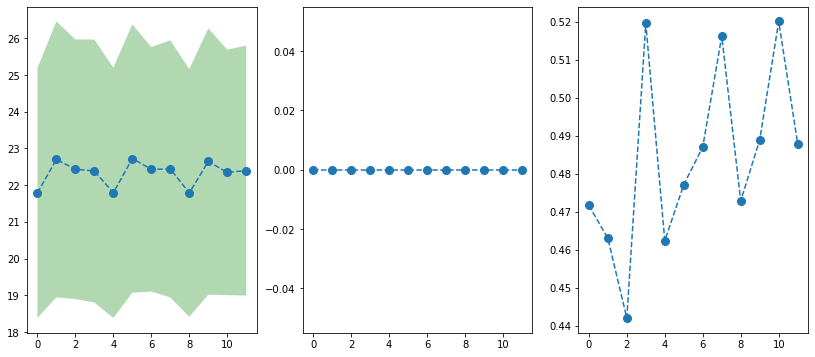

In [124]:
fig, axes = plt.subplots(figsize=(14, 6), ncols=3)
OX = np.arange(len(params.scenario) * 3)
num_rounds_active = get_num_rounds_active(journals_1, len(params.scenario) * 3)
axes[0].plot(OX, num_rounds_active[0], marker='o', markersize=8, linestyle='--')
axes[0].fill_between(OX, num_rounds_active[0] - num_rounds_active[1], num_rounds_active[0] + num_rounds_active[1], facecolor='green', alpha=0.3)

# FIXME: bad results:
num_tags_active = get_num_tags_active(journals_1, len(params.scenario) * 3)
axes[1].plot(OX, num_tags_active[0], marker='o', markersize=8, linestyle='--')
axes[1].fill_between(OX, num_tags_active[0] - num_tags_active[1], num_tags_active[0] + num_tags_active[1], facecolor='green', alpha=0.3)

axes[2].plot(OX, get_id_probs(journals_1, len(params.scenario) * 3), marker="o", markersize=8, linestyle='--')